## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Use inline plotting for Jupyter
%matplotlib inline

## Path & Visualization

In [2]:
def generate_global_path(path_type='semicircle'):
    """
    Generate different types of global paths for testing
    
    Args:
        path_type: 'semicircle', 's_curve', 'zigzag', 'race_track'
    
    Returns:
        cx, cy: lists of x and y coordinates
    """
    if path_type == 'semicircle':
        # Original path: straight, curve around obstacle, continue straight
        cx, cy = [], []
        
        # Segment 1: Approach
        for i in np.arange(0, 5, 0.1):
            cx.append(i)
            cy.append(0)
            
        # Segment 2: Curve around implicit obstacle (radius 5 semi-circle)
        # Center of turn at (5, 5)
        for i in np.arange(-math.pi/2, 0, 0.1):
            cx.append(5 + 5 * math.cos(i))  # X moves from 5 to 10
            cy.append(5 + 5 * math.sin(i))  # Y moves from 0 to 5
            
        # Segment 3: Continue straight away
        for i in np.arange(10, 20, 0.1):
            cx.append(i)
            cy.append(5)
        
        return cx, cy
        
    elif path_type == 'zigzag':
        # Sharp zigzag pattern (challenging for path following)
        cx, cy = [], []
        
        # Create zigzag segments
        segments = [
            (0, 0, 4, 0),      # Start straight
            (4, 0, 6, 3),      # Diagonal up-right
            (6, 3, 8, 3),      # Short straight
            (8, 3, 10, 0),     # Diagonal down-right
            (10, 0, 12, 0),    # Short straight
            (12, 0, 14, 4),    # Diagonal up-right
            (14, 4, 16, 4),    # Short straight
            (16, 4, 18, 1),    # Diagonal down-right
            (18, 1, 22, 1),    # Final straight
        ]
        
        for x1, y1, x2, y2 in segments:
            num_points = int(math.sqrt((x2-x1)**2 + (y2-y1)**2) / 0.1)
            for i in range(num_points):
                t = i / max(num_points - 1, 1)
                cx.append(x1 + t * (x2 - x1))
                cy.append(y1 + t * (y2 - y1))
        
        return cx, cy
    
    elif path_type == 'race_track':
        # Oval racing track with smooth curves (like NASCAR/F1)
        cx, cy = [], []
        
        # Track parameters
        straight_length = 15
        curve_radius = 6
        
        # Start at bottom left (before the track)
        start_x, start_y = -3, 0
        
        # Segment 0: Approach to track
        for i in np.arange(-3, 0, 0.1):
            cx.append(i)
            cy.append(start_y)
        
        # Segment 1: Bottom straight (left to right)
        for i in np.arange(0, straight_length, 0.1):
            cx.append(i)
            cy.append(start_y)
        
        # Segment 2: Right curve (bottom to top)
        center_x = straight_length
        center_y = curve_radius
        for angle in np.arange(-math.pi/2, math.pi/2, 0.05):
            cx.append(center_x + curve_radius * math.cos(angle))
            cy.append(center_y + curve_radius * math.sin(angle))
        
        # Segment 3: Top straight (right to left)
        for i in np.arange(straight_length, 0, -0.1):
            cx.append(i)
            cy.append(2 * curve_radius)
        
        # Segment 4: Left curve (top to bottom)
        center_x = 0
        center_y = curve_radius
        for angle in np.arange(math.pi/2, 3*math.pi/2, 0.05):
            cx.append(center_x + curve_radius * math.cos(angle))
            cy.append(center_y + curve_radius * math.sin(angle))
        
        # --- MODIFIED SEGMENT 5 ---
        # Segment 5: Exit the track (Curve OUTWARDS to the right/down)
        # We use a parabola (y = -ax^2) to ensure the turn starts smooth (tangent to y=0)
        # and then pulls away from the track.
        for i in np.arange(0, 10, 0.1):
            cx.append(i)
            cy.append(-0.05 * i**2)  # Curves down to y = -5
        
        return cx, cy
    
    else:
        raise ValueError(f"Unknown path_type: {path_type}. Choose 'semicircle', 's_curve', 'zigzag', or 'race_track'")


In [3]:
def visualize_all_paths():
    """Show all three path types side by side"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    path_types = ['semicircle', 'zigzag', 'race_track',]
    
    for idx, path_type in enumerate(path_types):
        gx, gy = generate_global_path(path_type)
        axes[idx].plot(gx, gy, '-g', linewidth=2, label='Global Path')
        axes[idx].set_title(f'{path_type.replace("_", " ").title()} Path', fontsize=14, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].axis('equal')
        axes[idx].set_xlabel('X (m)')
        axes[idx].set_ylabel('Y (m)')
        
        # Mark start and end
        axes[idx].plot(gx[0], gy[0], 'go', markersize=10, label='Start')
        axes[idx].plot(gx[-1], gy[-1], 'r*', markersize=15, label='Goal')
        
        # Add implicit obstacle marker for semicircle
        if path_type == 'semicircle':
            axes[idx].plot(8, 2, "ok", markersize=8, label="Implicit Obstacle")
        
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()


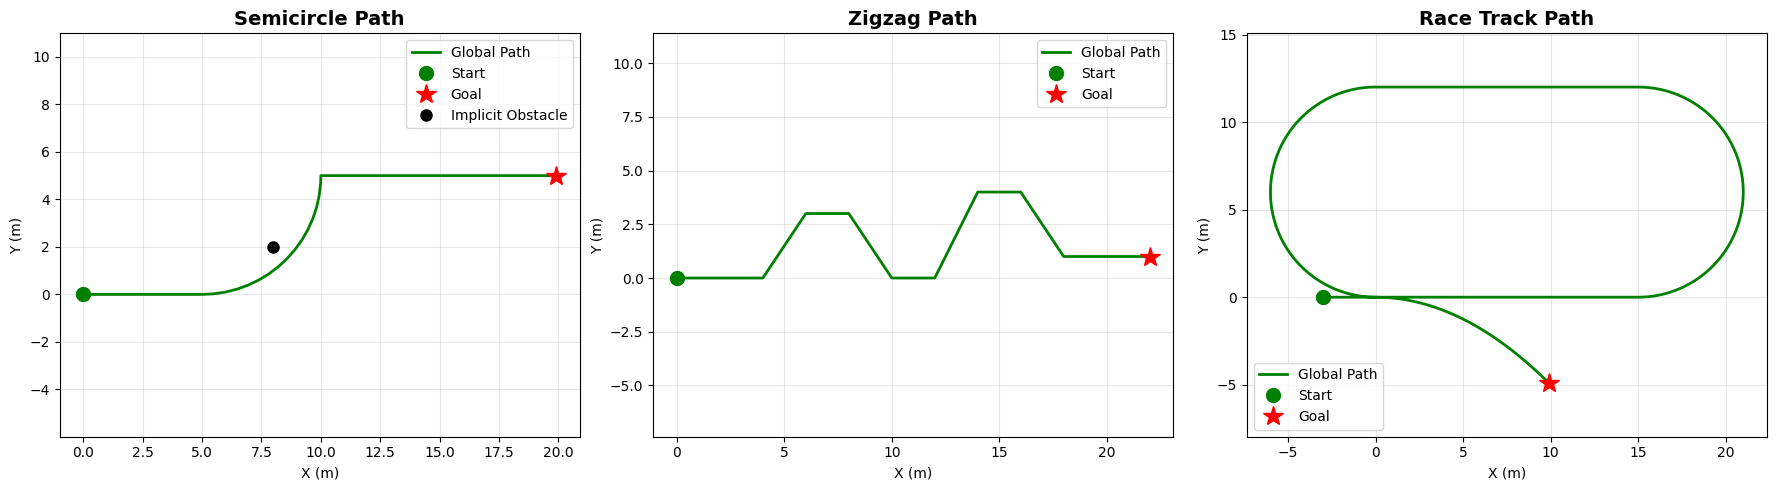

In [4]:
visualize_all_paths()

## Local Planner

1. Find lookahead point on global path
2. Check if obstacles block the path ──► YES ──► Compute avoidance target
                                     │               (perpendicular deviation)
                                     │
                                     └──► NO ──► Use original lookahead point
3. Calculate steering angle (alpha) to target
4. Apply Pure Pursuit formula: w = 2*v*sin(alpha)/L
5. Return (v, w) commands

In [5]:
def local_planner(current_pose, global_path_x, global_path_y, lookahead_dist, 
                  last_index=0,  # <--- NEW: Tracks progress to prevent shortcuts
                  obstacles=None, safe_margin=0.5, max_v=0.5, max_w=1.0):
    """
    Pure Pursuit local planner with dynamic obstacle avoidance and path tracking.
    """
    x, y, theta = current_pose
    
    # --- STEP 1: Find target using Windowed Search ---
    # We only look at points reasonably close to our last known position.
    # This prevents the robot from jumping from index 0 (Start) to index 500 (Finish)
    # just because they happen to be physically close on a looped track.
    search_window = 50 
    
    # Define search range based on last known index
    start_search = last_index
    end_search = min(last_index + search_window, len(global_path_x))
    
    # If we are at the very end, just look at the last segment
    if start_search >= len(global_path_x) - 1:
        start_search = len(global_path_x) - 1
        end_search = len(global_path_x)

    distances = []
    # Calculate distances only for points in the window
    for i in range(start_search, end_search):
        d = math.sqrt((global_path_x[i] - x)**2 + (global_path_y[i] - y)**2)
        distances.append(d)
    
    if not distances:
        current_path_index = last_index
    else:
        # Find closest point within the window
        min_local_index = np.argmin(distances)
        current_path_index = start_search + min_local_index
    
    # Find lookahead point starting from our current path index
    target_idx = current_path_index
    
    # Search forward from the closest point to find the lookahead point
    for i in range(current_path_index, len(global_path_x)):
        dist = math.sqrt((global_path_x[i] - x)**2 + (global_path_y[i] - y)**2)
        if dist >= lookahead_dist:
            target_idx = i
            break
            
    tx = global_path_x[target_idx]
    ty = global_path_y[target_idx]
    
    # --- STEP 2: Obstacle Avoidance ---
    avoiding = False
    if obstacles is not None and len(obstacles) > 0:
        for obs in obstacles:
            obs_x, obs_y, obs_radius = obs
            obs_dist = math.sqrt((obs_x - x)**2 + (obs_y - y)**2)
            
            detection_range = lookahead_dist + safe_margin
            if obs_dist > detection_range:
                continue
            
            angle_to_obs = math.atan2(obs_y - y, obs_x - x)
            heading_diff = abs((angle_to_obs - theta + np.pi) % (2 * np.pi) - np.pi)
            
            if heading_diff > np.pi / 2:
                continue
            
            if is_obstacle_blocking_path(x, y, tx, ty, obs_x, obs_y, obs_radius + safe_margin):
                avoiding = True
                tx, ty = compute_avoidance_target(x, y, theta, obs_x, obs_y, 
                                                  obs_radius + safe_margin,
                                                  tx, ty, lookahead_dist)
                break 
    
    # --- STEP 3: Steering Control ---
    angle_to_target = math.atan2(ty - y, tx - x)
    alpha = angle_to_target - theta
    alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
    
    L = math.sqrt((tx - x)**2 + (ty - y)**2)
    L = max(L, 0.01)
    
    v = max_v
    if abs(alpha) > np.pi / 4:
        v = max_v * 0.5
    if avoiding:
        v = max_v * 0.6
    
    w = 2.0 * v * math.sin(alpha) / L
    w = np.clip(w, -max_w, max_w)
    
    # --- STEP 4: Goal Slowdown ---
    # Only slow down if we are physically close to the end point AND index is high
    dist_to_final = math.sqrt((x - global_path_x[-1])**2 + (y - global_path_y[-1])**2)
    if dist_to_final < 1.0 and target_idx > len(global_path_x) - 20:
        v = v * (dist_to_final / 1.0)
        v = max(v, 0.1) # Minimum speed to reach goal

    return v, w, target_idx, avoiding

# --- Helper Functions for Planner ---
def is_obstacle_blocking_path(x1, y1, x2, y2, obs_x, obs_y, obs_radius):
    dx = x2 - x1
    dy = y2 - y1
    length = math.sqrt(dx**2 + dy**2)
    if length < 0.01: return False
    dx /= length
    dy /= length
    to_obs_x = obs_x - x1
    to_obs_y = obs_y - y1
    projection = to_obs_x * dx + to_obs_y * dy
    if projection < 0 or projection > length: return False
    closest_x = x1 + projection * dx
    closest_y = y1 + projection * dy
    dist = math.sqrt((obs_x - closest_x)**2 + (obs_y - closest_y)**2)
    return dist < obs_radius

def compute_avoidance_target(robot_x, robot_y, robot_theta, obs_x, obs_y, obs_radius, original_tx, original_ty, lookahead_dist):
    to_obs_x = obs_x - robot_x
    to_obs_y = obs_y - robot_y
    dist_to_obs = math.sqrt(to_obs_x**2 + to_obs_y**2)
    if dist_to_obs < 0.01: return original_tx, original_ty
    to_obs_x /= dist_to_obs
    to_obs_y /= dist_to_obs
    perp_left_x, perp_left_y = -to_obs_y, to_obs_x
    perp_right_x, perp_right_y = to_obs_y, -to_obs_x
    avoidance_dist = obs_radius * 1.5
    left_x = robot_x + perp_left_x * avoidance_dist
    left_y = robot_y + perp_left_y * avoidance_dist
    right_x = robot_x + perp_right_x * avoidance_dist
    right_y = robot_y + perp_right_y * avoidance_dist
    if math.sqrt((left_x - original_tx)**2 + (left_y - original_ty)**2) < math.sqrt((right_x - original_tx)**2 + (right_y - original_ty)**2):
        return left_x, left_y
    return right_x, right_y


## Simulation

In [6]:
def run_simulation_with_obstacles(path_type='semicircle', scenario='default'):
    dt = 0.1
    max_steps = 10000 # Increased
    gx, gy = generate_global_path(path_type)
    
    # Initial Poses & Obstacles (Copied from your code)
    if path_type == 'semicircle':
        pose = [0.0, -0.5, 0.0]
        if scenario == 'default': obstacles = [[3.0, 0.0, 0.4], [8.0, 2.0, 0.5], [15.0, 5.0, 0.4]]
        elif scenario == 'heavy_traffic': obstacles = [[2.0, 0.0, 0.3], [4.0, 0.5, 0.35], [6.5, 3.0, 0.4], [8.0, 3.5, 0.35], [9.0, 4.0, 0.4], [12.0, 5.0, 0.35], [15.0, 5.0, 0.4], [18.0, 5.0, 0.3]]
        else: obstacles = [[7.0, 1.5, 0.6], [8.5, 3.5, 0.6], [14.0, 5.0, 0.5], [14.0, 4.0, 0.5]]
    elif path_type == 's_curve':
        pose = [0.0, -0.5, 0.0]
        if scenario == 'default': obstacles = [[2.5, 0.0, 0.4], [6.0, 6.0, 0.5], [13.0, 2.0, 0.4], [19.0, 0.0, 0.4]]
        elif scenario == 'heavy_traffic': obstacles = [[2.0, 0.0, 0.3], [5.0, 3.0, 0.35], [6.5, 6.5, 0.4], [8.5, 7.5, 0.35], [11.5, 6.0, 0.4], [13.5, 3.0, 0.35], [17.0, 0.0, 0.4], [21.0, 0.0, 0.3]]
        else: obstacles = [[4.5, 3.5, 0.7], [7.5, 7.0, 0.7], [12.5, 5.5, 0.7], [14.0, 2.5, 0.7]]
    elif path_type == 'zigzag':
        pose = [0.0, -0.5, 0.0]
        if scenario == 'default': obstacles = [[5.0, 1.5, 0.4], [9.0, 1.5, 0.5], [13.0, 2.0, 0.4], [17.0, 2.5, 0.4]]
        elif scenario == 'heavy_traffic': obstacles = [[3.0, 0.0, 0.3], [5.0, 2.0, 0.35], [7.0, 3.0, 0.4], [9.0, 2.0, 0.35], [11.0, 0.5, 0.4], [13.0, 2.5, 0.35], [15.0, 4.0, 0.4], [19.0, 1.5, 0.3]]
        else: obstacles = [[5.0, 0.8, 0.6], [5.0, 2.2, 0.6], [9.0, 0.5, 0.6], [9.0, 2.5, 0.6], [13.0, 1.5, 0.6], [13.0, 3.5, 0.6]]
    elif path_type == 'race_track':
        pose = [-1.0, 0.0, 0.0]
        if scenario == 'default': obstacles = [[3.0, 0.0, 0.4], [12.0, 0.0, 0.5], [15.0, 6.0, 0.4], [3.0, 12.0, 0.5], [0.0, 6.0, 0.4]]
        elif scenario == 'heavy_traffic': obstacles = [[2.0, 0.0, 0.3], [5.0, 0.0, 0.35], [8.0, 0.0, 0.4], [11.0, 0.0, 0.35], [14.0, 0.0, 0.4], [16.0, 4.0, 0.35], [16.0, 8.0, 0.4], [13.0, 12.0, 0.35], [8.0, 12.0, 0.4], [3.0, 12.0, 0.35], [0.0, 8.0, 0.4], [0.0, 4.0, 0.35]]
        else: obstacles = [[7.0, 0.0, 0.7], [7.0, -1.0, 0.7], [7.0, 12.0, 0.7], [7.0, 13.0, 0.7], [17.0, 6.0, 0.7], [-1.0, 6.0, 0.7]]
    
    traj_x, traj_y = [], []
    avoidance_points_x, avoidance_points_y = [], []
    current_target_idx = 0 # Track index
    
    print(f"Starting simulation: {path_type} path with {scenario} obstacles...")
    
    for step in range(max_steps):
        v, w, target_idx, avoiding = local_planner(
            pose, gx, gy, 
            lookahead_dist=1.5,
            last_index=current_target_idx, # Pass history
            obstacles=obstacles,
            safe_margin=0.5,
            max_v=0.5,
            max_w=1.0
        )
        
        current_target_idx = target_idx # Update history
        if avoiding: avoidance_points_x.append(pose[0]); avoidance_points_y.append(pose[1])
        
        dist_to_goal = math.sqrt((pose[0] - gx[-1])**2 + (pose[1] - gy[-1])**2)
        if path_type == 'race_track':
            if dist_to_goal < 0.1 and target_idx > len(gx) * 0.9:
                print(f"Goal Reached at step {step}!"); break
        else:
            if dist_to_goal < 0.1:
                print(f"Goal Reached at step {step}!"); break
            
        pose[0] += v * math.cos(pose[2]) * dt
        pose[1] += v * math.sin(pose[2]) * dt
        pose[2] += w * dt
        pose[2] = (pose[2] + np.pi) % (2 * np.pi) - np.pi
        traj_x.append(pose[0]); traj_y.append(pose[1])
    
    print("Simulation finished.")
    
    # Visualization
    plt.figure(figsize=(14, 8))
    plt.plot(gx, gy, 'b--', linewidth=2, label='Global Path', alpha=0.6)
    plt.plot(traj_x, traj_y, 'g-', linewidth=2, label='Robot Trajectory')
    if avoidance_points_x: plt.scatter(avoidance_points_x, avoidance_points_y, c='orange', s=20, label='Avoiding', alpha=0.5)
    for i, obs in enumerate(obstacles):
        plt.gca().add_patch(plt.Circle((obs[0], obs[1]), obs[2], color='red', alpha=0.5, label='Obstacle' if i == 0 else ''))
        plt.gca().add_patch(plt.Circle((obs[0], obs[1]), obs[2] + 0.5, color='red', alpha=0.1, linestyle='--'))
    if path_type == 'semicircle': plt.plot(8, 2, "ok", markersize=8, label="Implicit Obstacle")
    if traj_x: plt.plot(traj_x[0], traj_y[0], 'go', markersize=10, label='Start')
    plt.plot(gx[-1], gy[-1], 'r*', markersize=15, label='Goal')
    plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    plt.title(f'Local Planner: {path_type} - {scenario}')
    plt.legend(); plt.grid(True, alpha=0.3); plt.axis('equal'); plt.tight_layout()
    plt.show()

In [7]:
def test_all_scenarios():
    """Run all path types and scenarios (12 total combinations)"""
    scenarios = ['default', 'heavy_traffic', 'narrow_passage']
    paths = ['semicircle', 'zigzag', 'race_track']
    
    for path in paths:
        for scenario in scenarios:
            print(f"\n{'='*60}")
            print(f"Testing: {path} with {scenario}")
            print(f"{'='*60}")
            run_simulation_with_obstacles(path, scenario)
            input("Press Enter to continue to next test...")


Testing: semicircle with default
Starting simulation: semicircle path with default obstacles...
Goal Reached at step 572!
Simulation finished.


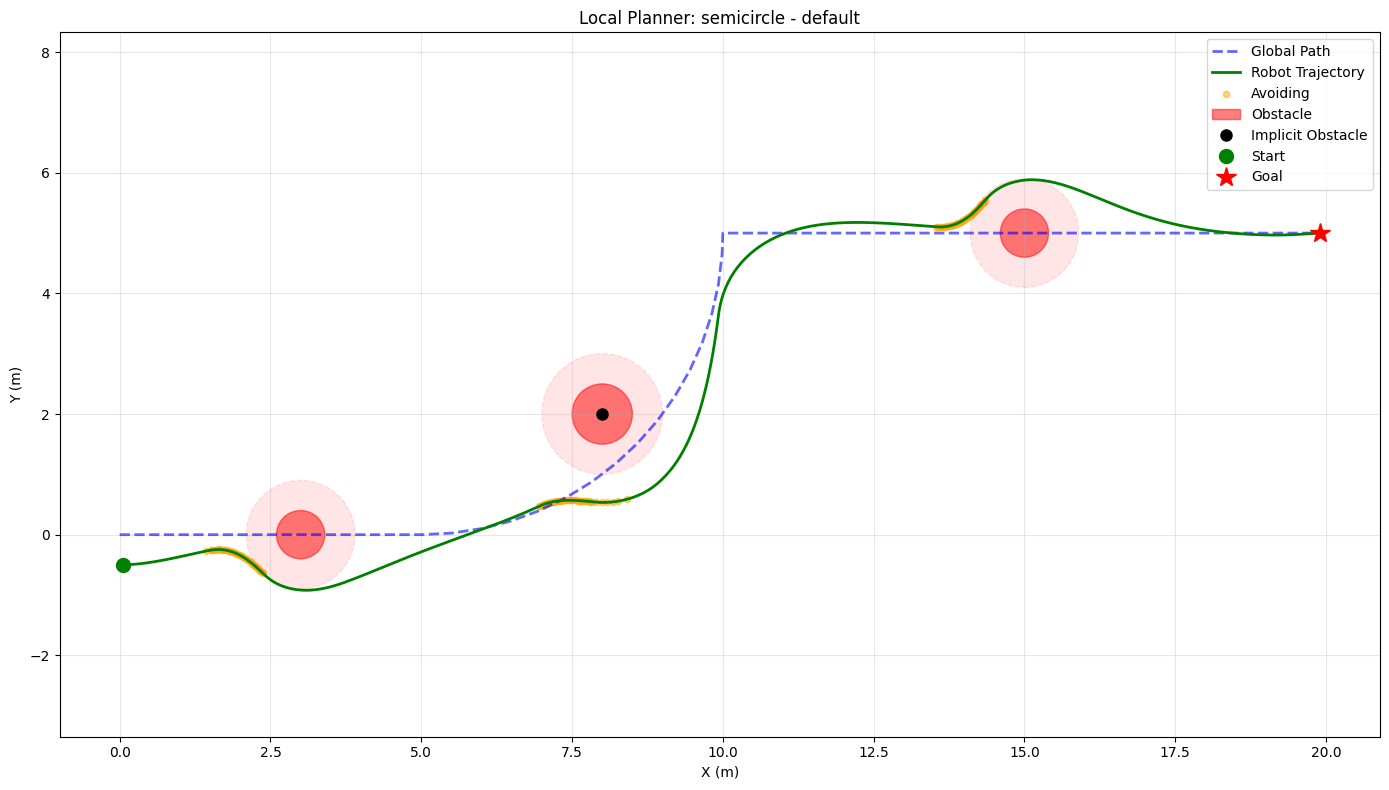


Testing: semicircle with heavy_traffic
Starting simulation: semicircle path with heavy_traffic obstacles...
Goal Reached at step 595!
Simulation finished.


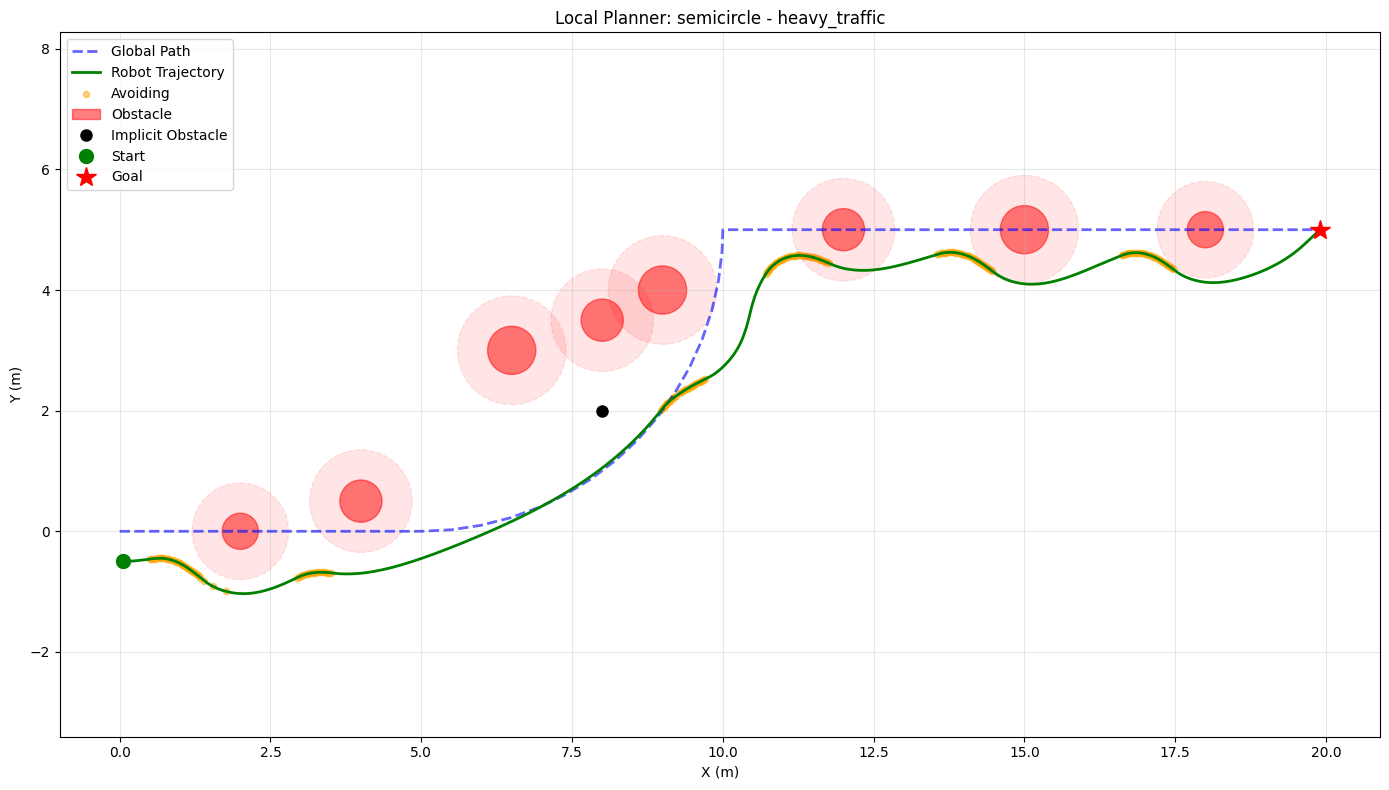


Testing: semicircle with narrow_passage
Starting simulation: semicircle path with narrow_passage obstacles...
Goal Reached at step 534!
Simulation finished.


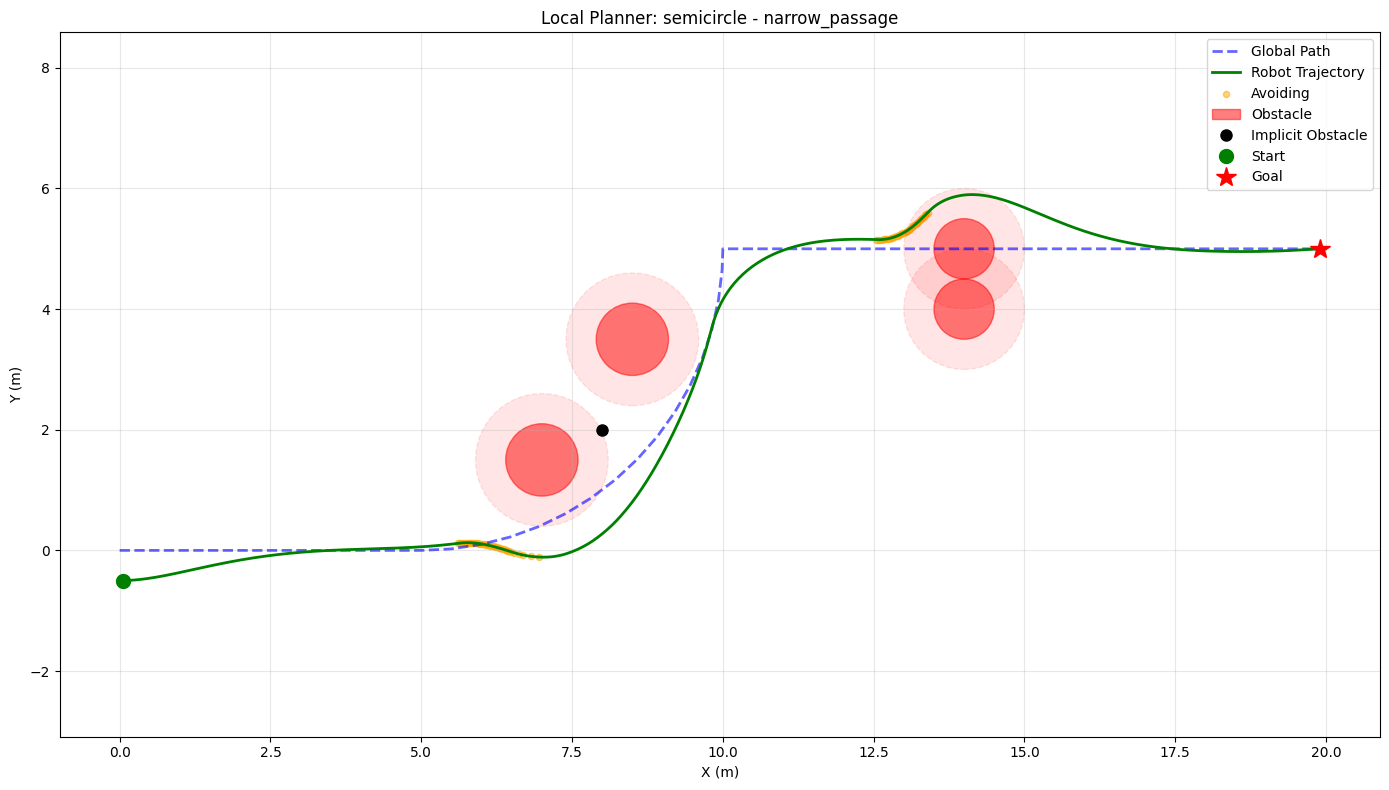


Testing: zigzag with default
Starting simulation: zigzag path with default obstacles...
Goal Reached at step 734!
Simulation finished.


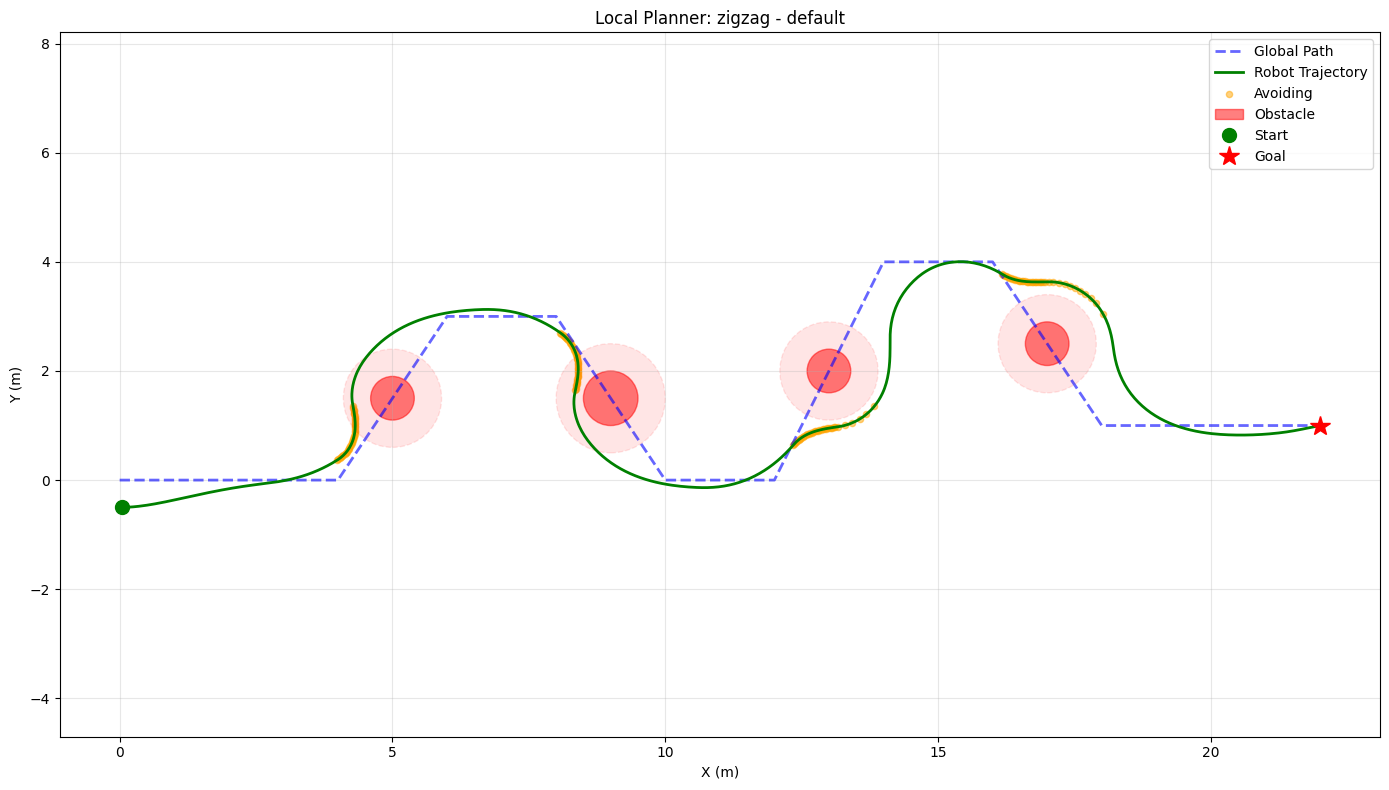


Testing: zigzag with heavy_traffic
Starting simulation: zigzag path with heavy_traffic obstacles...
Goal Reached at step 775!
Simulation finished.


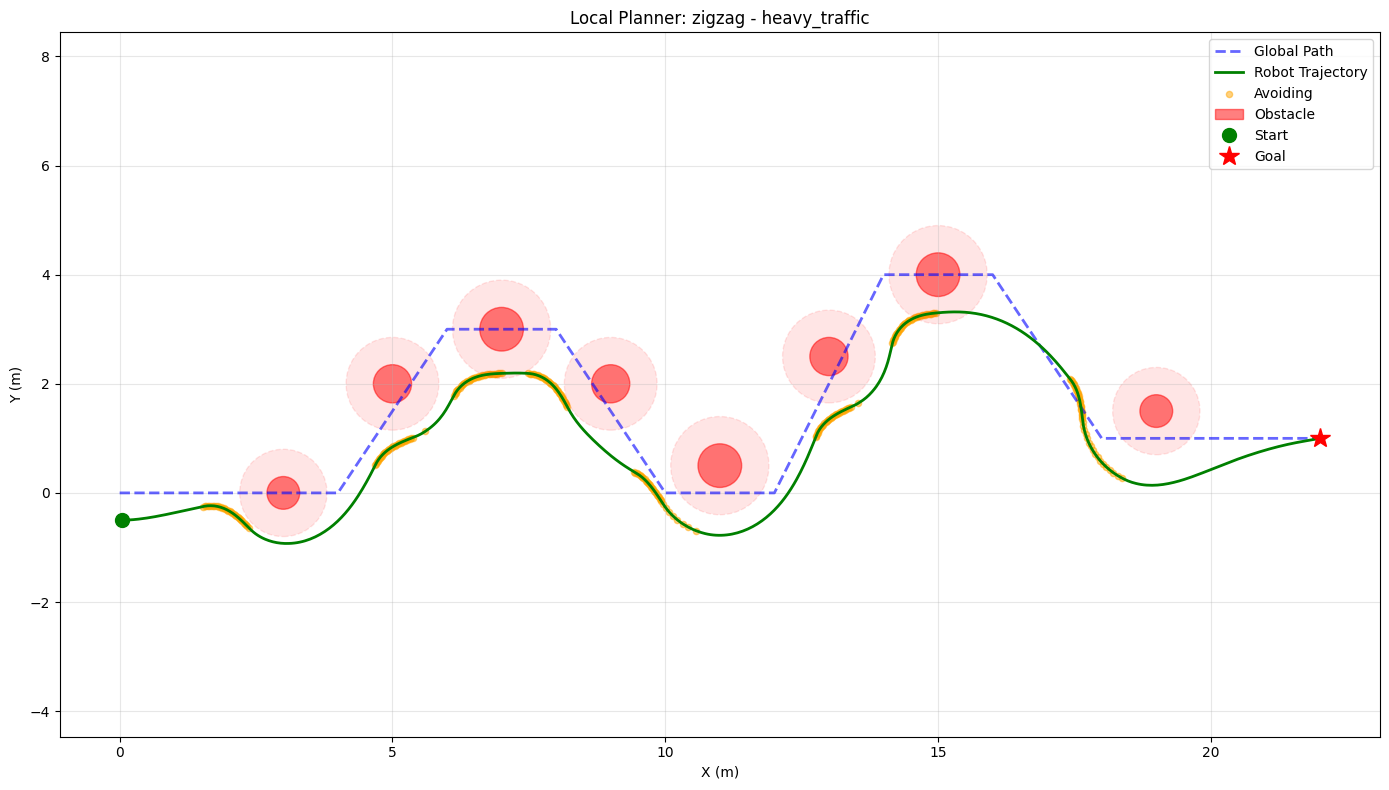


Testing: zigzag with narrow_passage
Starting simulation: zigzag path with narrow_passage obstacles...
Goal Reached at step 662!
Simulation finished.


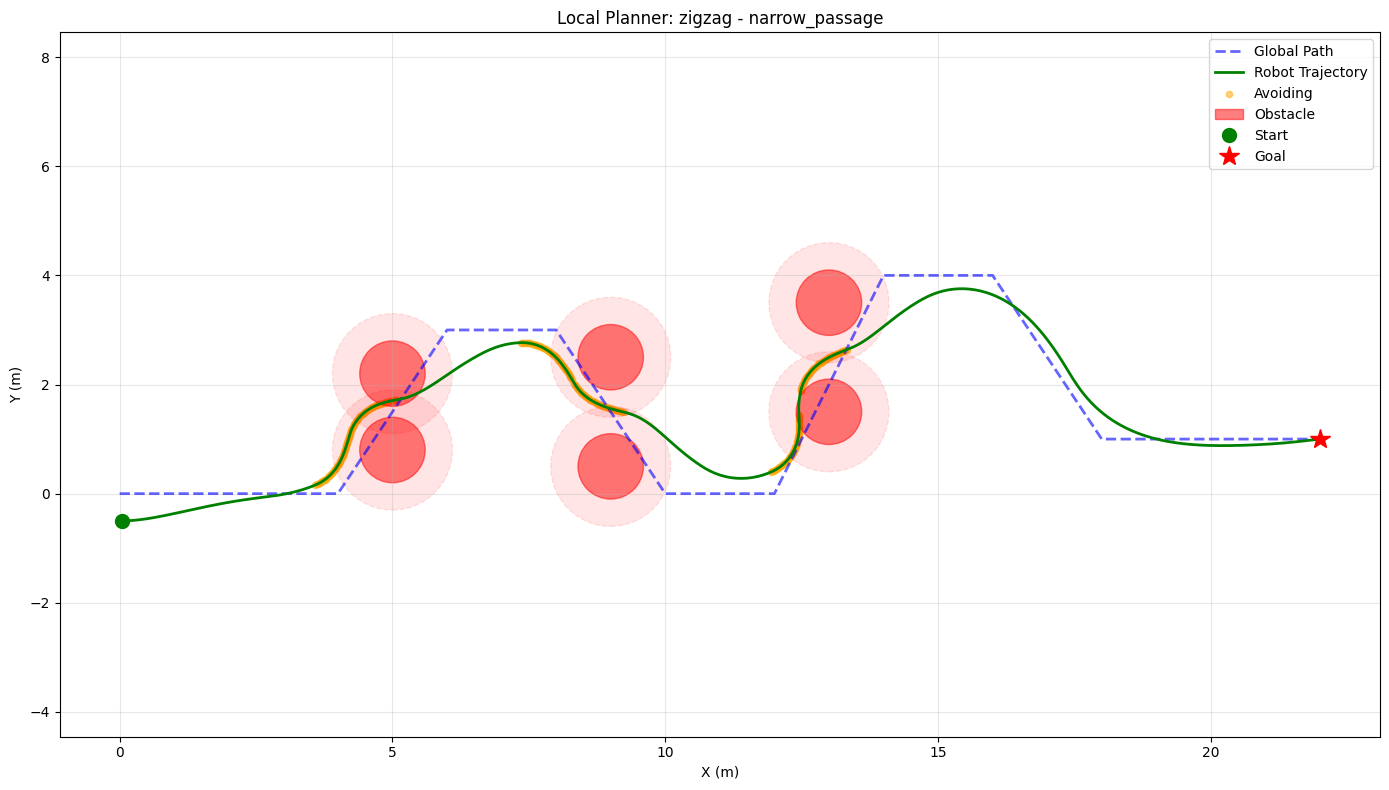


Testing: race_track with default
Starting simulation: race_track path with default obstacles...
Goal Reached at step 1750!
Simulation finished.


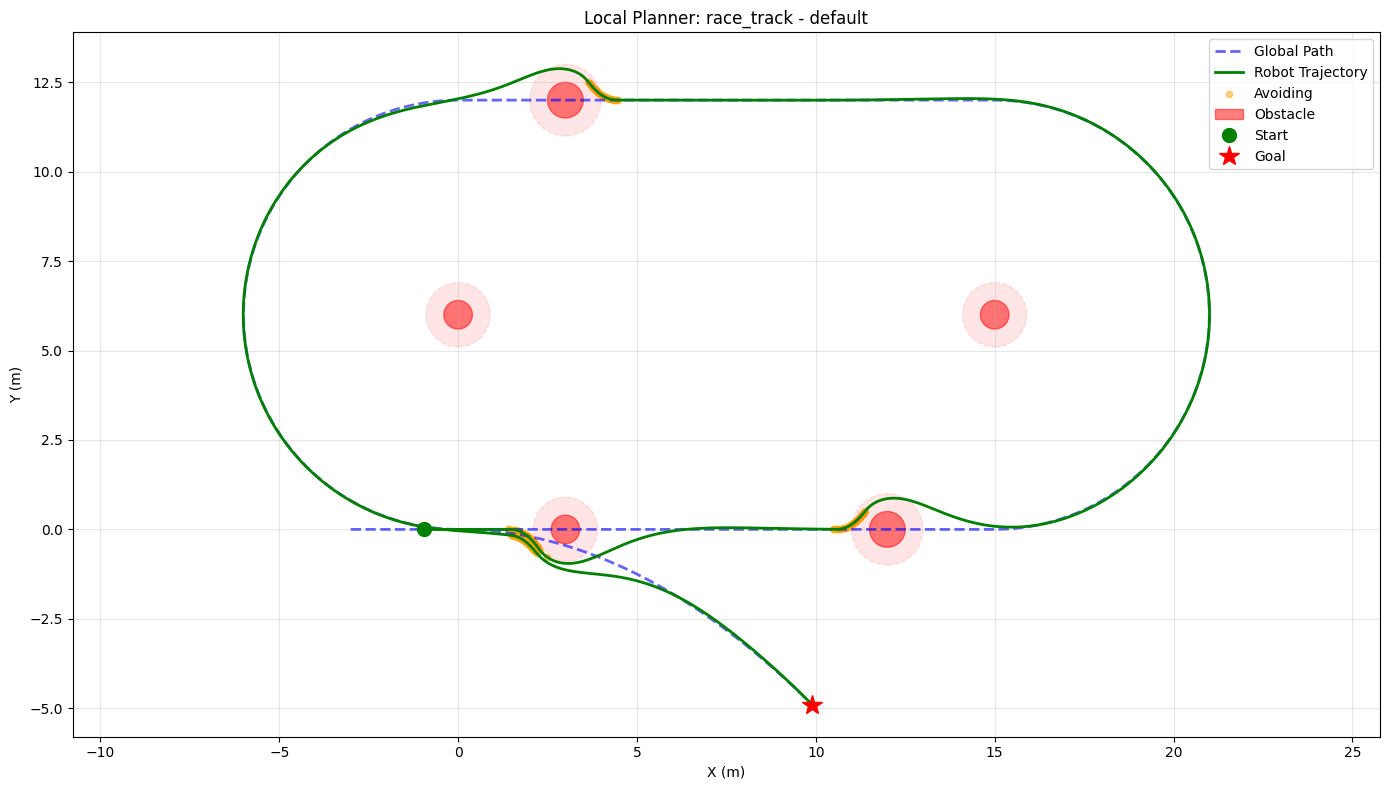


Testing: race_track with heavy_traffic
Starting simulation: race_track path with heavy_traffic obstacles...
Goal Reached at step 1914!
Simulation finished.


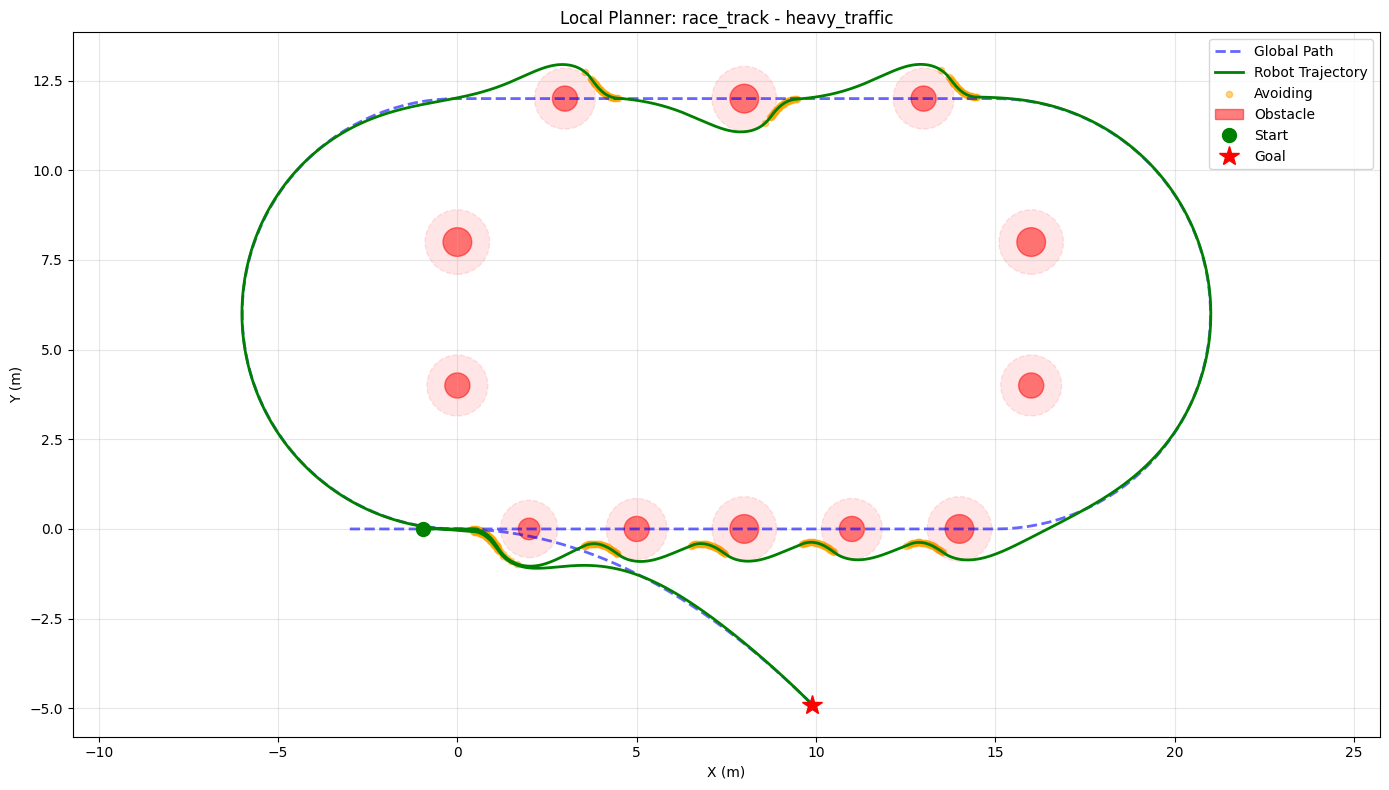


Testing: race_track with narrow_passage
Starting simulation: race_track path with narrow_passage obstacles...
Goal Reached at step 1688!
Simulation finished.


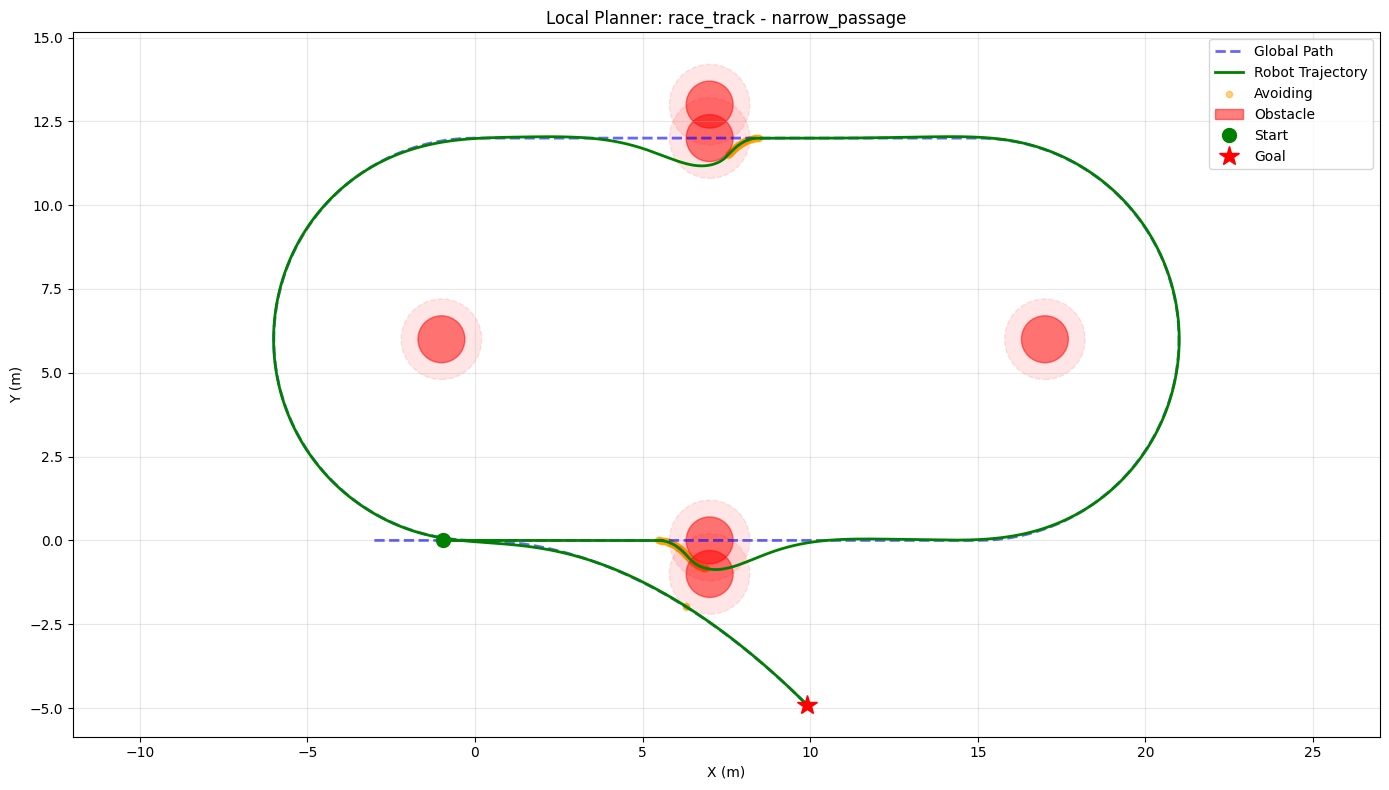

In [8]:
test_all_scenarios()

In [9]:
def run_simple_simulation(path_type='semicircle'):
    dt = 0.1
    max_steps = 10000 # Increased for long tracks
    gx, gy = generate_global_path(path_type)
    
    # Smart Start Position
    if path_type == 'race_track':
        pose = [-3.5, 0.0, 0.0] 
    else:
        pose = [0.0, -0.5, 0.0]

    traj_x, traj_y = [], []
    current_target_idx = 0 # Track index
    
    print(f"Running simple path following on {path_type}...")
    
    for step in range(max_steps):
        v, w, target_idx, _ = local_planner(
            pose, gx, gy,
            lookahead_dist=1.5,
            last_index=current_target_idx, # Pass history
            obstacles=None,
            max_v=0.5,
            max_w=1.0
        )
        
        current_target_idx = target_idx # Update history
        
        # Check Goal
        dist_to_goal = math.sqrt((pose[0] - gx[-1])**2 + (pose[1] - gy[-1])**2)
        if path_type == 'race_track':
            if dist_to_goal < 0.1 and target_idx > len(gx) * 0.9:
                print(f"Goal reached at step {step}!")
                break
        else:
            if dist_to_goal < 0.1:
                print(f"Goal reached at step {step}!")
                break
        
        pose[0] += v * math.cos(pose[2]) * dt
        pose[1] += v * math.sin(pose[2]) * dt
        pose[2] += w * dt
        pose[2] = (pose[2] + np.pi) % (2 * np.pi) - np.pi
        
        traj_x.append(pose[0])
        traj_y.append(pose[1])
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(gx, gy, 'b--', linewidth=2, label='Global Path', alpha=0.6)
    plt.plot(traj_x, traj_y, 'g-', linewidth=2, label='Robot Trajectory')
    plt.plot(traj_x[0], traj_y[0], 'go', markersize=10, label='Start')
    plt.plot(gx[-1], gy[-1], 'r*', markersize=15, label='Goal')
    if path_type == 'semicircle': plt.plot(8, 2, "ok", markersize=8, label="Implicit Obstacle")
    plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    plt.title(f'Pure Path Following - {path_type}')
    plt.legend(); plt.grid(True, alpha=0.3); plt.axis('equal'); plt.tight_layout()
    plt.show()

Running simple path following on semicircle...
Goal reached at step 467!


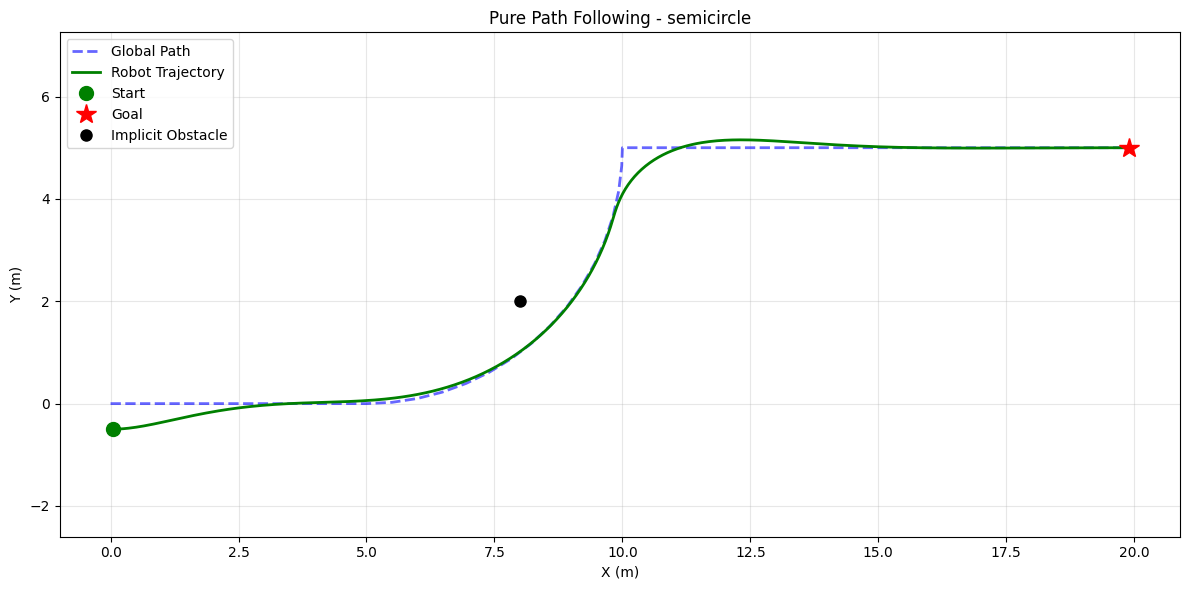

Running simple path following on zigzag...
Goal reached at step 577!


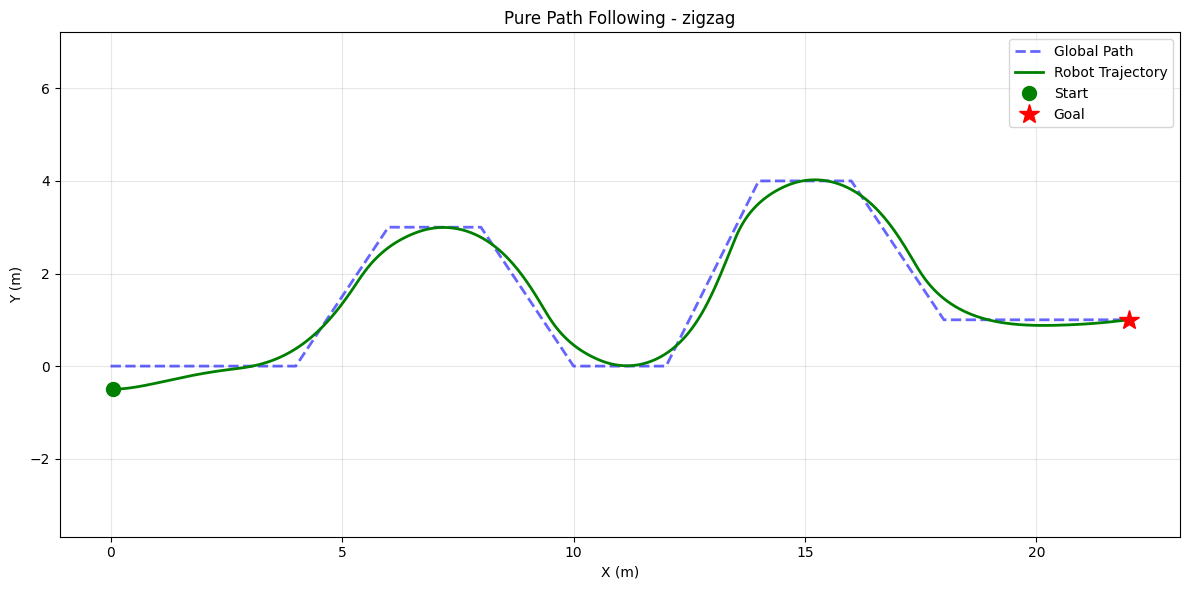

Running simple path following on race_track...
Goal reached at step 1673!


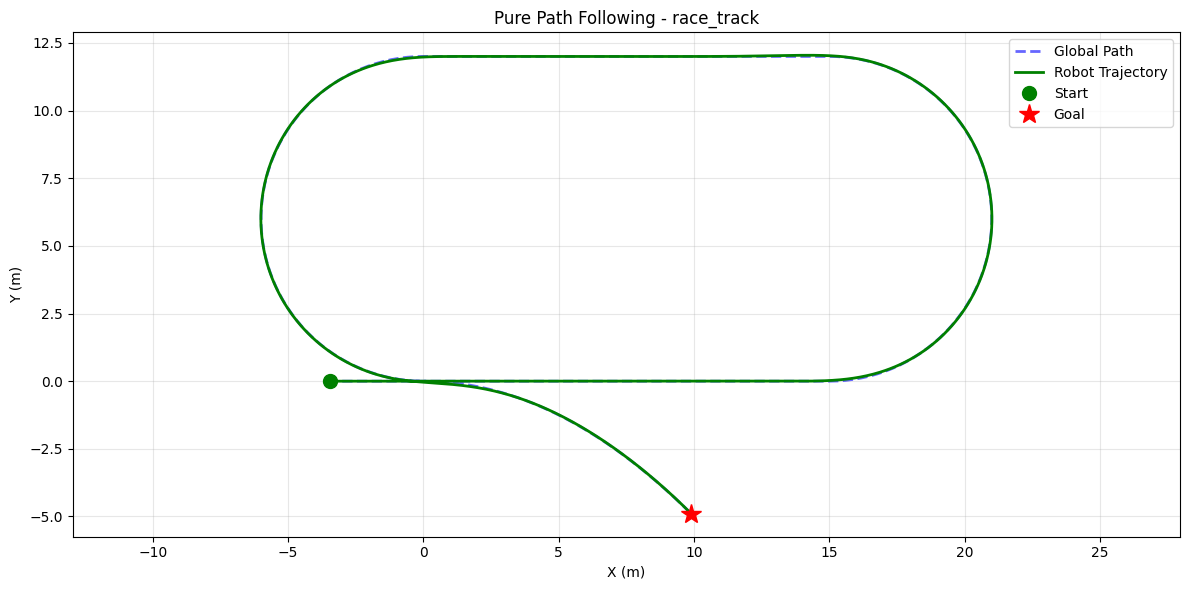

In [12]:
run_simple_simulation('semicircle')
run_simple_simulation('zigzag')
run_simple_simulation('race_track')